# day 229

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import os
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# 1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.


In [2]:
# downloading the image data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# unzipping the files
zip = zipfile.ZipFile('101_food_classes_10_percent.zip')
zip.extractall()
zip.close()

--2023-11-13 12:23:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  29.2MB/s    in 41s     

2023-11-13 12:23:41 (37.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
# batchifying the data folders in tensorflow
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=[224,224],
                                                         label_mode='int',
                                                         batch_size=32,
                                                         shuffle=True)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=[224,224],
                                                        label_mode='int',
                                                        batch_size=32,
                                                        shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [4]:
# create the Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [5]:
# create model checkpoint callbacks
path = 'model_checkpoints'

ModelCheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(path,
                                                     monitor='val_accuracy',
                                                     save_best_only=True,
                                                     save_weights_only=True)

In [6]:
# build the feature extractor model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freeze all the layers make it untrainable
base_model.trainable = False

# create the input layers
input_layer = tf.keras.Input(shape=[224,224,3],name='input_layer')

# put the input layer inside data augmentation layer
x = data_augmentation(input_layer)

# put the above layer inside base model
x = base_model(x,training=False)

# put the above layer inside GlobalAveragePooling2D
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# put the above layer inside the output layer
class_names = train_data.class_names
output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax',name='output_layer')(x)

# creating our first model
model0 = tf.keras.Model(input_layer,output_layer)


# compiling our model
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
tf.random.set_seed(42)

feature_extractor_epochs = 5
model0.fit(train_data,
           epochs=feature_extractor_epochs,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=int(0.15*len(test_data)),
           callbacks=[ModelCheckpoint_callback])

24274472/24274472 [==============================] - 1s 0us/step
Epoch 1/5
237/237 [==============================] - 48s 127ms/step - loss: 3.5174 - accuracy: 0.2455 - val_loss: 2.6788 - val_accuracy: 0.4502
Epoch 2/5
237/237 [==============================] - 30s 127ms/step - loss: 2.4444 - accuracy: 0.4396 - val_loss: 2.2352 - val_accuracy: 0.4942
Epoch 3/5
237/237 [==============================] - 35s 147ms/step - loss: 2.0633 - accuracy: 0.5133 - val_loss: 2.0505 - val_accuracy: 0.5069
Epoch 4/5
237/237 [==============================] - 29s 123ms/step - loss: 1.8422 - accuracy: 0.5552 - val_loss: 1.9537 - val_accuracy: 0.5138
Epoch 5/5
237/237 [==============================] - 32s 133ms/step - loss: 1.6901 - accuracy: 0.5925 - val_loss: 1.8553 - val_accuracy: 0.5299


In [7]:
# fine-tuning
# make the entire base model trianable
base_model.trainable = True

# refreeze all the layers except few at the end near the output:
for layer in base_model.layers[:-5]:
  layer.trainable = False

# recompile the model with 10 times low learning rate
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

# fit the model
total_epochs = feature_extractor_epochs + 5

history0 = model0.fit(train_data,
           epochs=total_epochs,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=int(0.15*len(test_data)),
           initial_epoch=feature_extractor_epochs,
           callbacks=[ModelCheckpoint_callback])


Epoch 6/10
237/237 [==============================] - 41s 123ms/step - loss: 1.4777 - accuracy: 0.6345 - val_loss: 1.7988 - val_accuracy: 0.5262
Epoch 7/10
237/237 [==============================] - 27s 112ms/step - loss: 1.3772 - accuracy: 0.6430 - val_loss: 1.7718 - val_accuracy: 0.5352
Epoch 8/10
237/237 [==============================] - 30s 126ms/step - loss: 1.3104 - accuracy: 0.6611 - val_loss: 1.7553 - val_accuracy: 0.5373
Epoch 9/10
237/237 [==============================] - 28s 118ms/step - loss: 1.2758 - accuracy: 0.6647 - val_loss: 1.7562 - val_accuracy: 0.5416
Epoch 10/10
237/237 [==============================] - 28s 118ms/step - loss: 1.2370 - accuracy: 0.6778 - val_loss: 1.7471 - val_accuracy: 0.5400


1/1 [==============================] - 2s 2s/step


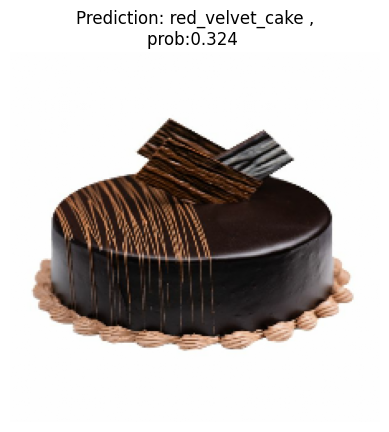

In [8]:
# visualizing 3 images of my choosing

def show(url):
  # read the url
  image = requests.get(url).content

  # decode the image with 3 channels
  image = tf.io.decode_image(image,channels=3)

  # resize the image
  image = tf.image.resize(image,[224,224])

  # expand a dimension of the image
  image = tf.expand_dims(image,axis=0)

  # make prediction with the image;
  prediction = model0.predict(image)[0]
  pred_prob = max(prediction)
  pred_label = class_names[prediction.argmax()]

  # view the image
  plt.imshow(tf.squeeze(image)/255.)
  plt.title('Prediction: {} ,\nprob:{:.3f} '.format(pred_label,pred_prob))
  plt.axis('off')
  plt.show()









url = 'https://www.dangeedums.com/pub/media/catalog/product/cache/fae149c33723746542368d9b15043c52/c/r/crunchy-chocolate-cake-900gm.jpg'

show(url)


1/1 [==============================] - 0s 27ms/step


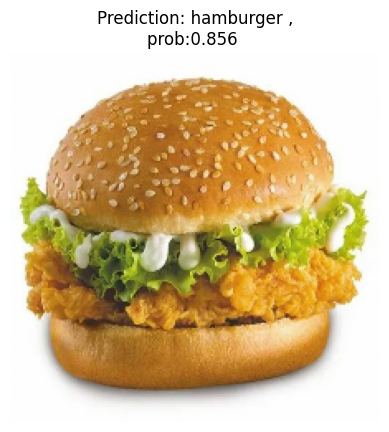

In [9]:
url = 'https://5.imimg.com/data5/SELLER/Default/2020/10/JW/IH/YG/42388148/veg-burgers-500x500.jpg'
show(url)

1/1 [==============================] - 0s 26ms/step


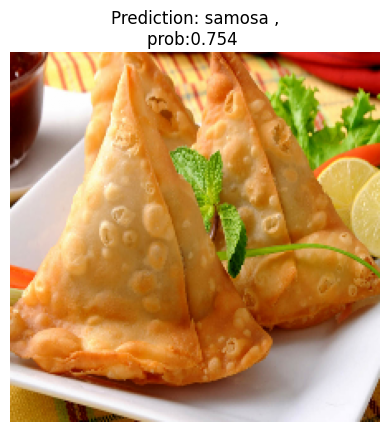

In [10]:
url = 'https://static.toiimg.com/thumb/55453664.cms?width=1200&height=900'
show(url)

#2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [ ]:
# base_model creation
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# keep the base_model untrainable to create a feature extractor model
base_model.trainable = False

# input_layers
input_layer = tf.keras.Input(shape=[224,224,3],name='input_layer')

# input into augmentation layer
x = data_augmentation(input_layer)

# into base_model
x = base_model(x,training=False)

# GlobalAveragePooling2D
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# output layer
output_layer = tf.keras.layers.Dense(len(class_names),activation='softmax',name='output_layer')(x)

# create the model1
model1 = tf.keras.Model(input_layer,output_layer)

# compile the model
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['accuracy'])

# fit the model
feature_extractor_epochs = 10
history1 = model1.fit(train_data,
                      epochs=feature_extractor_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[ModelCheckpoint_callback])

Epoch 1/10
237/237 [==============================] - 36s 112ms/step - loss: 3.5444 - accuracy: 0.2334 - val_loss: 2.7897 - val_accuracy: 0.3750
Epoch 2/10
237/237 [==============================] - 30s 124ms/step - loss: 2.4251 - accuracy: 0.4490 - val_loss: 2.2720 - val_accuracy: 0.4642
Epoch 3/10
237/237 [==============================] - 38s 158ms/step - loss: 2.0621 - accuracy: 0.5135 - val_loss: 2.0625 - val_accuracy: 0.4897
Epoch 4/10
237/237 [==============================] - 34s 138ms/step - loss: 1.8447 - accuracy: 0.5583 - val_loss: 1.9600 - val_accuracy: 0.5135
Epoch 5/10
237/237 [==============================] - 24s 100ms/step - loss: 1.6799 - accuracy: 0.5914 - val_loss: 1.8475 - val_accuracy: 0.5291
Epoch 6/10
237/237 [==============================] - 23s 96ms/step - loss: 1.5721 - accuracy: 0.6098 - val_loss: 1.8132 - val_accuracy: 0.5294
Epoch 7/10
237/237 [==============================] - 24s 100ms/step - loss: 1.4739 - accuracy: 0.6356 - val_loss: 1.7345 - val_acc

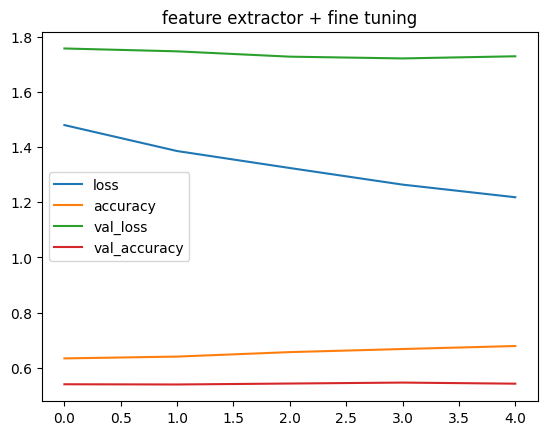

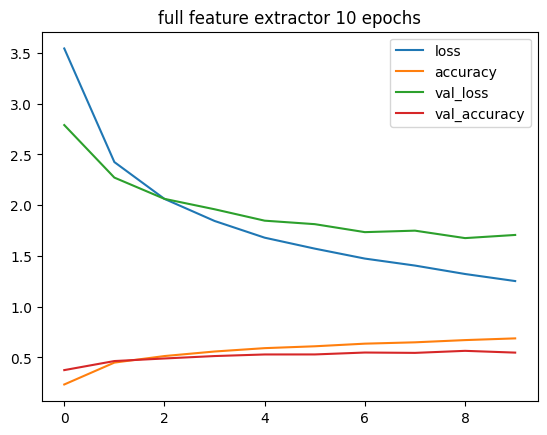

In [ ]:
pd.DataFrame(history0.history).plot()
plt.title('feature extractor + fine tuning')
plt.show()


pd.DataFrame(history1.history).plot()
plt.title('full feature extractor 10 epochs')
plt.show()

# conclusion:
## I don't see much difference

# 3. Recreate the first model (the feature extraction model) with mixed_precision turned on.


# 32 bit,64bit or 16 bit?
* float16 data gets processed faster in memory (RAM) than float 32 or float 64. Higher the precision lower the speed.
* but lower precision might decrease the numerical stability for example the model's val_accuracy might get affected and lowered.
* using mixed precision in the feature extractor model is about using both float32 and float16.
* float16 for speed and performance.
* float32 for precision and stability.
* Adding a float16 softmax in the middle of a model is fine, but a softmax at the end of the model should be in float32. The reason is that if the intermediate tensor flowing from the softmax to the loss is float16 or bfloat16, numeric issues may occur.

# Underflow and Overflow
The float16 data type has a narrow dynamic range compared to float32. This means values above 65504 will `overflow to infinity` and values below 6.0 x 10^-8 will `underflow to 0`. float32 and bfloat16 have a much higher dynamic range so that overflow and underflow are not a problem.

# Loss scaling overview
* The basic concept of loss scaling is simple: simply multiply the loss by some large number, say
12345, and you get the loss scale value. This will cause the gradients to scale by 12345 as well, greatly reducing the chance of underflow. Once the final gradients are computed, divide them by to bring them back to their correct values.
* To solve this, TensorFlow dynamically determines the loss scale so you do not have to choose one manually. If you use tf.keras.Model.fit, loss scaling is done for you so you do not have to do any extra work. If you use a custom training loop, you must explicitly use the special optimizer wrapper tf.keras.mixed_precision.LossScaleOptimizer in order to use loss scaling. This is described in the next section.

# GPU performance tips
Here are some performance tips when using mixed precision on GPUs.

## Increasing your batch size
If it doesn't affect model quality, try running with double the batch size when using mixed precision. As float16 tensors use half the memory, this often allows you to double your batch size without running out of memory. Increasing batch size typically increases training throughput, i.e. the training elements per second your model can run on.

## Ensuring GPU Tensor Cores are used
As mentioned previously, modern NVIDIA GPUs use a special hardware unit called Tensor Cores that can multiply float16 matrices very quickly. However, Tensor Cores requires certain dimensions of tensors to be a multiple of 8. In the examples below, an argument is bold if and only if it needs to be a multiple of 8 for Tensor Cores to be used. like tf.keras.layers.Dense(64 or 32 or 16 units) like setting the hidden layers to the multiple of 8.

# steps:
* run this code in the begginning: tf.keras.mixed_precision.set_global_policy('mixed_float16')
* make the output's dtype = 'float32'.

# summary:
questions:
1. Does it make the model train faster?
2. Does it effect the accuracy or performance of our model?
3. What's the advantages of using mixed_precision training?

ans:
1. yes it trains the model faster. it seems to have sped up the process of training by 8.411% about ~16% for every 10 epochs. But if were to train for more epochs the time reduction in training would have been significant.
2. yes it seems to improved the accuracy of validation data but the change is insignificant.
3. mixed precision speeds up the training process reducing the time consumption drastically (16% is huge!!!).




In [11]:
# to check the name of our GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-80624019-891e-97ba-74b5-c98514c2aab7)


In [12]:
# setting up the mixed_precision policy
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# printing it out
policy = tf.keras.mixed_precision.Policy('mixed_float16')
print('computational precision: {} , variables precision: {} '.format(policy.compute_dtype,policy.variable_dtype))

computational precision: float16 , variables precision: float32 


In [14]:
# lets build the model now
""" the differences are listed below:
1. output layer has dtype= 'float32'.
"""
# base model without output layers
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# freeze all the layers of the base_model
base_model.trainable = False

# input layer
input_layer = tf.keras.Input(shape=[224,224,3],name='input_layer')

# data augmentation
x = data_augmentation(input_layer)

# into base model
x = base_model(x,training=False)

# into GlobalAveragePooling2D
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

# outputlayer (with explicit setting of dtype to float32)
output_layer = tf.keras.layers.Dense(len(class_names),dtype='float32',activation='softmax',name='output_layer')(x)

# create the model2
model2 = tf.keras.Model(input_layer,output_layer)

# compile the model
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
feature_extractor_epochs = 5
history2 = model2.fit(train_data,
           epochs=feature_extractor_epochs,
           steps_per_epoch=len(train_data),
           validation_data=test_data,
           validation_steps=int(0.15*len(test_data)),
           callbacks=[ModelCheckpoint_callback])


Epoch 1/5
237/237 [==============================] - 39s 124ms/step - loss: 3.5472 - accuracy: 0.2333 - val_loss: 2.7840 - val_accuracy: 0.4102
Epoch 2/5
237/237 [==============================] - 27s 114ms/step - loss: 2.4323 - accuracy: 0.4437 - val_loss: 2.2545 - val_accuracy: 0.4780
Epoch 3/5
237/237 [==============================] - 28s 116ms/step - loss: 2.0521 - accuracy: 0.5176 - val_loss: 2.0332 - val_accuracy: 0.5148
Epoch 4/5
237/237 [==============================] - 27s 112ms/step - loss: 1.8467 - accuracy: 0.5521 - val_loss: 1.9377 - val_accuracy: 0.5193
Epoch 5/5
237/237 [==============================] - 26s 108ms/step - loss: 1.6995 - accuracy: 0.5916 - val_loss: 1.8341 - val_accuracy: 0.5453


# 4. Spend 15-minutes reading up on the EarlyStopping callback. What does it do? How could we use it in our model training?

* it stops the training when the monitoring metric doesn't seem to improve after a set threshold of iterations.

* example: `callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)`.

* This callback will stop the training when there is no improvement in the loss for three consecutive epochs.

# 5. Spend an hour reading about Streamlit. What does it do? How might you integrate some of the things we've done in this notebook in a Streamlit app?

In [15]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [17]:
import streamlit as st

In [21]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [35]:
st.write('''my first poopap''')
st.line_chart(data=df,x='age',y='charges',color='sex')


DeltaGenerator()

<Axes: xlabel='age', ylabel='charges'>

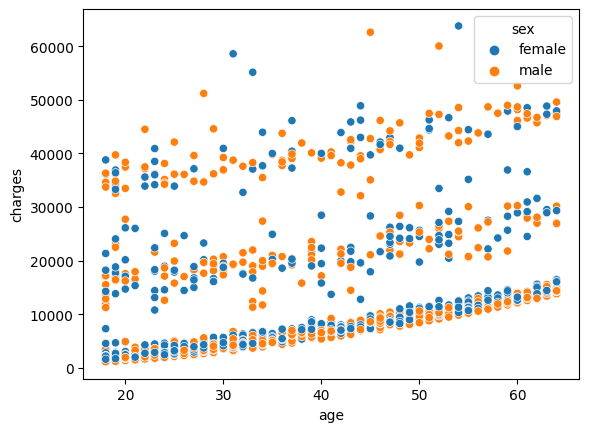

In [38]:
sns.scatterplot(data=df,x='age',y='charges',hue='sex')

In [40]:
number = st.slider('pick a number',0,100)
number

0

In [41]:
st.button('Hit me!')

False